## Load and Prepare Dataset

In [1]:
# ------------------------------------------
# Imports and Setup
# ------------------------------------------
# pandas is used for data manipulation and analysis (e.g., loading and cleaning the dataset)
import pandas as pd
# PyTorch core components for model building and training
import torch
import torch.nn as nn            # Neural network layers and operations
import torch.optim as optim      # Optimization algorithms (e.g., Adam)
# Utility for handling datasets and batch loading
from torch.utils.data import DataLoader, TensorDataset
# Train/test data splitting
from sklearn.model_selection import train_test_split
# Convert raw text into TF-IDF feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer
# Encode categorical labels into integers
from sklearn.preprocessing import LabelEncoder
# To evaluate model performance (precision, recall, f1-score, etc.)
from sklearn.metrics import classification_report
# For saving and loading models, vectorizers, and encoders
import joblib
# NumPy for numerical computations
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For creating an interactive web UI for inference
import gradio as gr

# Force PyTorch to use CPU (this is useful for compatibility and deployment)
device = torch.device("cpu")


# ------------------------------------------
# Load and Prepare Dataset
# ------------------------------------------

# Load the dataset from a CSV file (assumed to be in the './dataset/' directory)
df = pd.read_csv("./dataset/Combined Data.csv")

# Drop any auto-generated index column (if it exists) to clean the data
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")

# Remove any rows where the 'statement' column is missing (null)
df.dropna(subset=["statement"], inplace=True)

# Remove any duplicate statements to avoid biasing the model
df.drop_duplicates(subset=["statement"], inplace=True)

# Preview the cleaned DataFrame (in a Jupyter notebook, this would display the table)
df

/home/ibrahim/jupyter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
52835,Anxiety cause faintness when standing up ? As ...,Anxiety
52836,anxiety heart symptom does anyone else have th...,Anxiety
52837,Travel Anxiety Hi all! Long time anxiety suffe...,Anxiety
52839,fomo from things i’m not involved in does anyo...,Anxiety


## Exploratory Data Analysis (EDA)

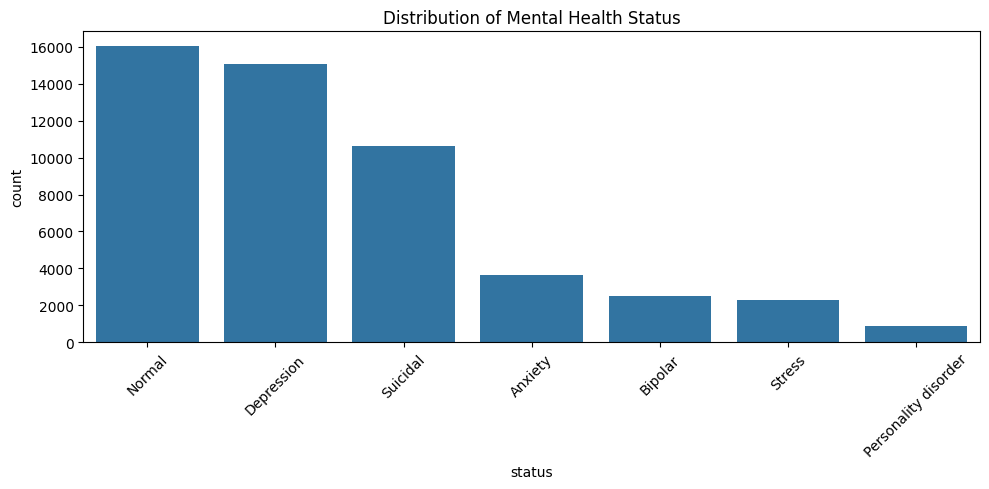

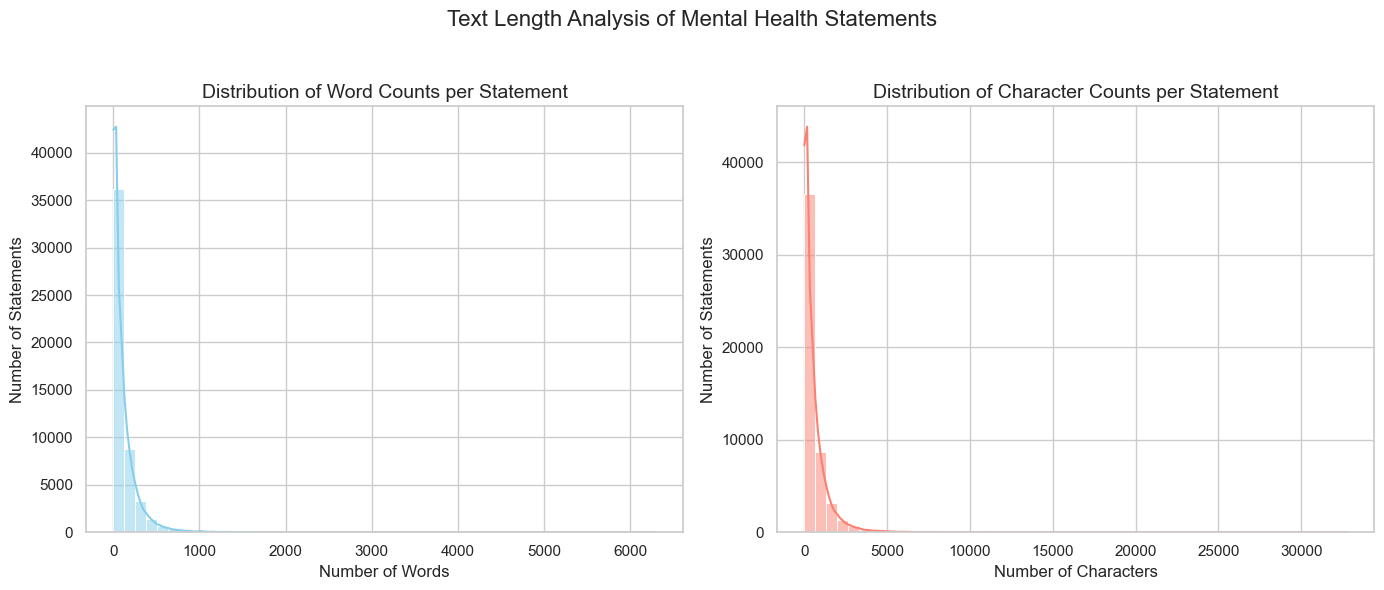

In [2]:
# -------------------------------
# Visualize the distribution of 'status' categories in the dataset
# -------------------------------

# Set the figure size for the plot
plt.figure(figsize=(10, 5))

# Create a count plot (bar chart) showing the frequency of each 'status' value
# The 'order' argument ensures the bars are sorted by frequency (descending)
sns.countplot(data=df, x="status", order=df["status"].value_counts().index)

# Set the title of the plot
plt.title("Distribution of Mental Health Status")

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Adjust the layout so labels and titles don’t overlap or get cut off
plt.tight_layout()

# Display the plot
plt.show()

# -------------------------------
# Prepare for histogram plotting with a consistent visual style
# -------------------------------

# Set a seaborn style with a white grid background for all upcoming plots
sns.set(style="whitegrid")

# Create a figure with 1 row and 2 columns of subplots for side-by-side histograms
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# -------------------------------
# Add new columns to the DataFrame to analyze text length
# -------------------------------

# Calculate the number of words in each statement (splitting text on whitespace)
df["word_count"] = df["statement"].apply(lambda x: len(str(x).split()))

# Calculate the number of characters in each statement
df["char_count"] = df["statement"].apply(lambda x: len(str(x)))

# -------------------------------
# Plot histogram of word counts per statement
# -------------------------------

# Use seaborn to create a histogram with 50 bins on the first subplot (ax[0])
# 'kde=True' adds a Kernel Density Estimate curve for smooth distribution shape
sns.histplot(df["word_count"], bins=50, ax=ax[0], color="skyblue", kde=True)

# Set title and axis labels for the first histogram
ax[0].set_title("Distribution of Word Counts per Statement", fontsize=14)
ax[0].set_xlabel("Number of Words", fontsize=12)
ax[0].set_ylabel("Number of Statements", fontsize=12)

# -------------------------------
# Plot histogram of character counts per statement
# -------------------------------

# Create a similar histogram for character counts on the second subplot (ax[1])
sns.histplot(df["char_count"], bins=50, ax=ax[1], color="salmon", kde=True)

# Set title and axis labels for the second histogram
ax[1].set_title("Distribution of Character Counts per Statement", fontsize=14)
ax[1].set_xlabel("Number of Characters", fontsize=12)
ax[1].set_ylabel("Number of Statements", fontsize=12)

# -------------------------------
# Finalize and show the combined plot
# -------------------------------

# Add a main title for the entire figure
plt.suptitle("Text Length Analysis of Mental Health Statements", fontsize=16)

# Adjust layout again, this time reserving space for the super title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the figure with both histograms
plt.show()


## Data Preprocessing

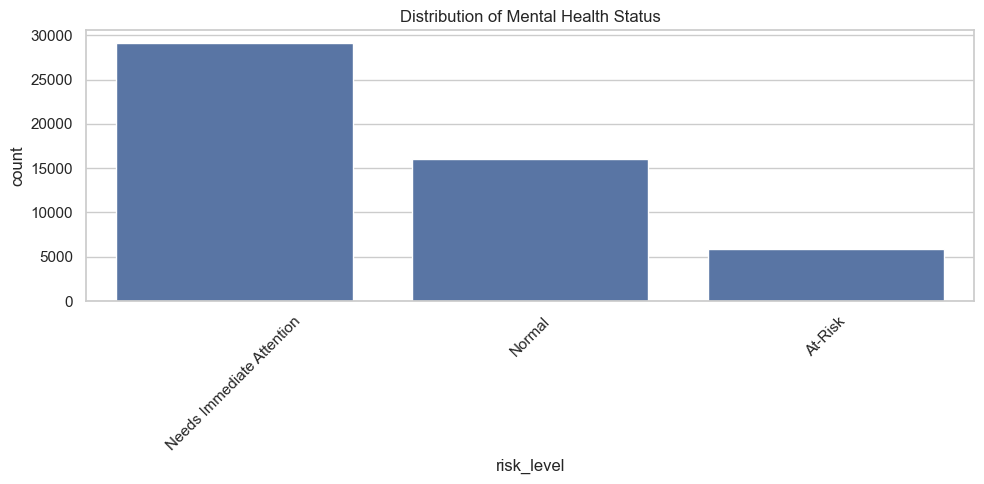

In [3]:
# ------------------------------------------
# 3. Map Original Labels to 3 Risk Levels
# ------------------------------------------

# Define a mapping from detailed mental health statuses to broader risk categories
status_to_risk = {
    "Normal": "Normal",  # No evident risk
    "Anxiety": "At-Risk",  # Potential mental health concern
    "Stress": "At-Risk",
    "Depression": "Needs Immediate Attention",  # Severe cases needing urgent support
    "Suicidal": "Needs Immediate Attention",
    "Bipolar": "Needs Immediate Attention",
    "Personality disorder": "Needs Immediate Attention"
}

# Create a new column 'risk_level' by mapping the 'status' column using the dictionary above
df["risk_level"] = df["status"].map(status_to_risk)

# Keep only rows with a valid mapped risk level (drop anything unexpected or unmapped)
df = df[df["risk_level"].isin(["Normal", "At-Risk", "Needs Immediate Attention"])].copy()

# ------------------------------------------
# 4. Text Preprocessing and Label Encoding
# ------------------------------------------

# Lowercase the statements for normalization (helps reduce feature sparsity)
df["processed_text"] = df["statement"].str.lower()

# Initialize label encoder to convert string labels (risk levels) into numerical labels
label_encoder = LabelEncoder()

# Encode the 'risk_level' column into a new numerical 'label' column
df["label"] = label_encoder.fit_transform(df["risk_level"])

# ------------------------------------------
# 5. TF-IDF Vectorization
# ------------------------------------------

# Initialize a TF-IDF vectorizer to convert text into numeric features (up to 5000 tokens)
vectorizer = TfidfVectorizer(max_features=5000)

# Apply the vectorizer to the processed text to create feature vectors
X = vectorizer.fit_transform(df["processed_text"]).toarray()

# Extract the encoded labels as the target variable
y = df["label"].values

# -------------------------------
# Visualize the distribution of new 'risk_level' categories in the dataset
# -------------------------------

# Set the figure size for the plot
plt.figure(figsize=(10, 5))

# Create a count plot (bar chart) showing the frequency of each 'status' value
# The 'order' argument ensures the bars are sorted by frequency (descending)
sns.countplot(data=df, x="risk_level", order=df["risk_level"].value_counts().index)

# Set the title of the plot
plt.title("Distribution of Mental Health Status")

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Adjust the layout so labels and titles don’t overlap or get cut off
plt.tight_layout()

# Display the plot
plt.show()


## CPU-based Custom Neural Network

In [4]:
# ------------------------------------------
# 6. Train-Test Split and Convert to Tensor
# ------------------------------------------

# Split the dataset into training and test sets (80/20 split), stratified to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert the numpy arrays into PyTorch tensors (float for features, long for labels)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap the tensors into PyTorch Datasets for batch loading
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch training and evaluation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # shuffle for training
test_loader = DataLoader(test_dataset, batch_size=64)

# ------------------------------------------
# 7. Define Custom Neural Network
# ------------------------------------------

# Define a neural network class inheriting from nn.Module
class MentalHealthClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MentalHealthClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.dropout = nn.Dropout(0.3)                  # Dropout to reduce overfitting
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = self.fc1(x)      # Pass through first layer
        x = self.relu(x)     # Apply ReLU
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)      # Final output logits
        return x

# Set input size based on TF-IDF feature size
input_dim = X_train.shape[1]

# Instantiate the model and move to CPU (or GPU if available)
model = MentalHealthClassifier(input_size=input_dim, hidden_size=128, num_classes=3).to(device)

# ------------------------------------------
# 8. Train the Model
# ------------------------------------------

# Use cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer for training
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs (training iterations over the full dataset)
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track loss

    # Iterate through each batch
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)  # Move data to device
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update model weights

        running_loss += loss.item()  # Accumulate loss

    # Print training progress
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

# ------------------------------------------
# 9. Evaluate the Model
# ------------------------------------------

model.eval()  # Set model to evaluation mode
all_preds = []   # Store predictions
all_labels = []  # Store true labels

# Disable gradient computation for evaluation
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())    # Collect actual labels

# ------------------------------------------
# 10. Print Classification Report
# ------------------------------------------

# Generate and print detailed classification metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# ------------------------------------------
# 11. Save Model and Vectorizer
# ------------------------------------------

# Save the model weights to disk
torch.save(model.state_dict(), "./models/mental_health_model.pth")

# Save the TF-IDF vectorizer and label encoder using joblib
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

# Confirm that files were saved
print("Model, vectorizer, and label encoder saved.")


Epoch [1/15], Loss: 250.8577
Epoch [2/15], Loss: 127.2220
Epoch [3/15], Loss: 102.3616
Epoch [4/15], Loss: 86.5646
Epoch [5/15], Loss: 72.8670
Epoch [6/15], Loss: 60.4912
Epoch [7/15], Loss: 50.0451
Epoch [8/15], Loss: 40.4057
Epoch [9/15], Loss: 32.2811
Epoch [10/15], Loss: 25.8573
Epoch [11/15], Loss: 20.8082
Epoch [12/15], Loss: 16.7132
Epoch [13/15], Loss: 13.7072
Epoch [14/15], Loss: 11.9240
Epoch [15/15], Loss: 9.8672

Classification Report:
                           precision    recall  f1-score   support

                  At-Risk       0.76      0.74      0.75      1182
Needs Immediate Attention       0.93      0.94      0.93      5825
                   Normal       0.91      0.90      0.91      3208

                 accuracy                           0.90     10215
                macro avg       0.87      0.86      0.86     10215
             weighted avg       0.90      0.90      0.90     10215

Model, vectorizer, and label encoder saved.


## Load Model & Test on Sample Posts (Inference Pipeline)

In [5]:
# ------------------------------------------
# Load the vectorizer and label encoder
# ------------------------------------------

# Load the saved TF-IDF vectorizer from disk (used to transform input text into numeric features)
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Load the saved label encoder (used to map numeric predictions back to risk level labels)
label_encoder = joblib.load("label_encoder.pkl")

# ------------------------------------------
# Recreate the Model Architecture
# ------------------------------------------

# Define the same model architecture as was used during training
class MentalHealthClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MentalHealthClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation for non-linearity
        self.dropout = nn.Dropout(0.3)                  # Dropout for regularization
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = self.fc1(x)      # Input to first layer
        x = self.relu(x)     # Apply activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)      # Final layer to get logits
        return x

# Instantiate the model with the same parameters used in training
model = MentalHealthClassifier(input_size=5000, hidden_size=128, num_classes=3)

# Load the model's saved weights (trained parameters)
model.load_state_dict(torch.load("./models/mental_health_model.pth", map_location=torch.device("cpu")))

# Set the model to evaluation mode (disables dropout and gradients)
model.eval()

# ------------------------------------------
# 13. Predict on New Posts
# ------------------------------------------

# Define a function to predict mental health risk levels for a list of text posts
def predict_risk(posts):
    # Preprocess: convert all input text to lowercase
    processed = [p.lower() for p in posts]
    
    # Transform the text using the TF-IDF vectorizer (same as during training)
    X = vectorizer.transform(processed).toarray()
    
    # Convert the feature array to a PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    # Disable gradient tracking since we're just making predictions
    with torch.no_grad():
        outputs = model(X_tensor)                   # Run the model to get logits
        _, preds = torch.max(outputs, 1)            # Get the index of the highest logit (predicted class)
        predicted_labels = label_encoder.inverse_transform(preds.numpy())  # Convert numerical labels to text
    
    # Return a list of (input_text, predicted_risk_level) tuples
    return list(zip(posts, predicted_labels))

# ------------------------------------------
# 14. Try Sample Inputs
# ------------------------------------------

# Define some example mental health-related statements to test the classifier
samples = [
    "I feel hopeless and tired of everything.",           # Should likely be 'Needs Immediate Attention'
    "I'm doing fine, just had a busy week.",              # Should likely be 'Normal'
    "I’ve been thinking about ending it all lately."      # Should definitely be 'Needs Immediate Attention'
]

# Get predictions for the sample inputs
results = predict_risk(samples)

# Print out each input and its corresponding predicted risk level
for post, prediction in results:
    print(f"Post: {post}\n → Prediction: {prediction}\n")


Post: I feel hopeless and tired of everything.
 → Prediction: Needs Immediate Attention

Post: I'm doing fine, just had a busy week.
 → Prediction: Normal

Post: I’ve been thinking about ending it all lately.
 → Prediction: At-Risk



/tmp/ipykernel_316876/1407378430.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/mental_health_model.pth", map_location=torch

## Gradio App

In [6]:
# ------------------------------------------
# Load Model, Vectorizer, and Encoder
# ------------------------------------------

# Load the saved TF-IDF vectorizer (used to convert input text into numeric features)
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Load the saved label encoder (used to map model output to risk level labels)
label_encoder = joblib.load("label_encoder.pkl")

# Define the same neural network architecture used during training
class MentalHealthClassifier(nn.Module):
    def __init__(self, input_size=5000, hidden_size=128, num_classes=3):
        super(MentalHealthClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.dropout = nn.Dropout(0.3)                  # Dropout for regularization
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Output layer (3 classes)

    def forward(self, x):
        x = self.fc1(x)      # Apply first linear transformation
        x = self.relu(x)     # Apply ReLU activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)      # Output logits
        return x

# Instantiate the model with default input/output dimensions
model = MentalHealthClassifier()

# Load the model's trained weights from disk
model.load_state_dict(torch.load("./models/mental_health_model.pth", map_location=torch.device("cpu")))

# Set model to evaluation mode (important to disable dropout during inference)
model.eval()

# ------------------------------------------
# Define Prediction Function
# ------------------------------------------

# Define a function that takes user input and returns the predicted risk label
def classify_risk(post):
    processed = post.lower()  # Convert input to lowercase for consistency
    X = vectorizer.transform([processed]).toarray()  # Convert to TF-IDF features
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Convert to PyTorch tensor

    with torch.no_grad():  # Disable gradient calculation
        output = model(X_tensor)                        # Run input through the model
        pred_class = torch.argmax(output, dim=1).item() # Get index of predicted class
        risk_label = label_encoder.inverse_transform([pred_class])[0]  # Map index to label
    
    return risk_label  # Return the predicted risk level (string)

# ------------------------------------------
# Launch Gradio Interface
# ------------------------------------------

# Create and launch a Gradio interface for the prediction function
gr.Interface(
    fn=classify_risk,  # The function that runs the model
    inputs=gr.Textbox(label="Enter a mental health-related statement:"),  # Text input box
    outputs=gr.Label(num_top_classes=3, label="Predicted Risk Level"),    # Label output with top classes
    title="🧠 Mental Health Risk Classifier",  # App title
    description="Classifies posts as Normal, At-Risk, or Needs Immediate Attention using a custom neural network and TF-IDF."  # Description
).launch()  # Start the Gradio app (opens in a new browser tab or window)


/tmp/ipykernel_316876/3139504247.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/mental_health_model.pth", map_location=torch

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
